In [2]:
import tensorflow as tf #library utama yaitu tensorflow untuk deep learning
from tensorflow.keras import layers #panggil fungsi layer untuk membuat layer neural network
import pandas as pd
import matplotlib.pyplot as plt #Untuk plotting dan baca gambar
from sklearn.model_selection import train_test_split #Fungsi pemisah dataset menjadi data training dan testing
import numpy as np #Library untuk manipulasi array

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
#Cek apakah ada CPU dan GPU
print('CPU: {}'.format(len(tf.config.list_physical_devices('CPU'))))
print('GPU: {}'.format(len(tf.config.list_physical_devices('GPU'))))

CPU: 1
GPU: 1


In [4]:
#Load dataset
data=pd.read_csv('fer2013.csv')

In [5]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [6]:
data['label']=data['emotion'] #Assign value pada kolom emotion ke kolom baru dengan nama 'label'
emotions={0:'Marah',1:'Jijik',2:'Takut',3:'Bahagia',4:'Sedih',5:'Terkejut',6:'Netral'} #Buat dictionary label value dan kategori
data['emotion']=data['emotion'].replace(emotions) #Mengganti label angka menjadi kategori

In [7]:
X = data['pixels'].apply(lambda x: np.array(x.split()).reshape(48, 48, 1).astype('float32')) #Ubah ukuran gambar ke 48x48x1
X = np.stack(X, axis=0) #Stack gambar
X.shape #Melihat ukuran tensor dataset gambar

(35887, 48, 48, 1)

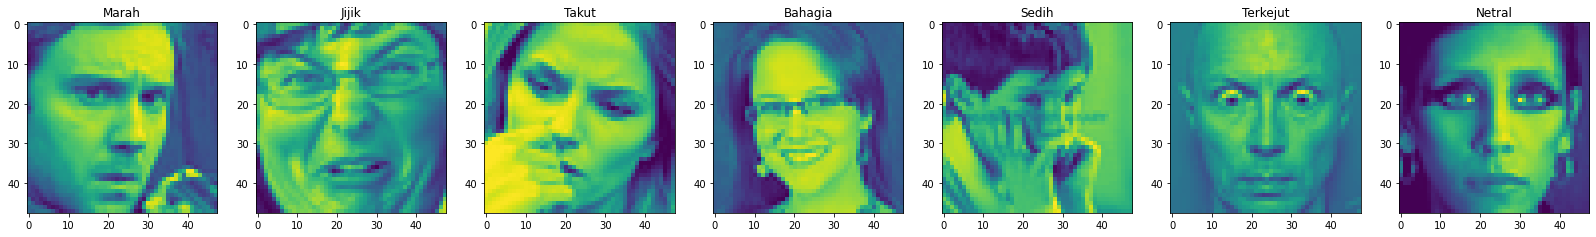

In [8]:
#Menampilkan contoh dataset per masing-masing kategori
fig,ax=plt.subplots(ncols=7,figsize=(28,4))
for i in range(7):
    ax[i].imshow(X[np.where(data['label'].values==i)][0]) #np.where mencari indeks keberapa untuk label kategori tertentu
    ax[i].set_title(emotions[i])

<AxesSubplot:>

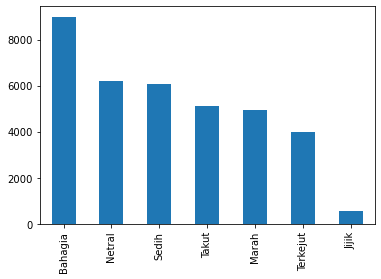

In [9]:
data.emotion.value_counts().plot(kind='bar') #Plot jumlah data per kategori

In [11]:
X_rgb=tf.image.grayscale_to_rgb(tf.constant(X)).numpy().astype(np.int32) #Convert gambar gray ke rgb
X_rgb.shape

2021-09-22 20:36:57.269227: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-22 20:36:57.273215: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



(35887, 48, 48, 3)

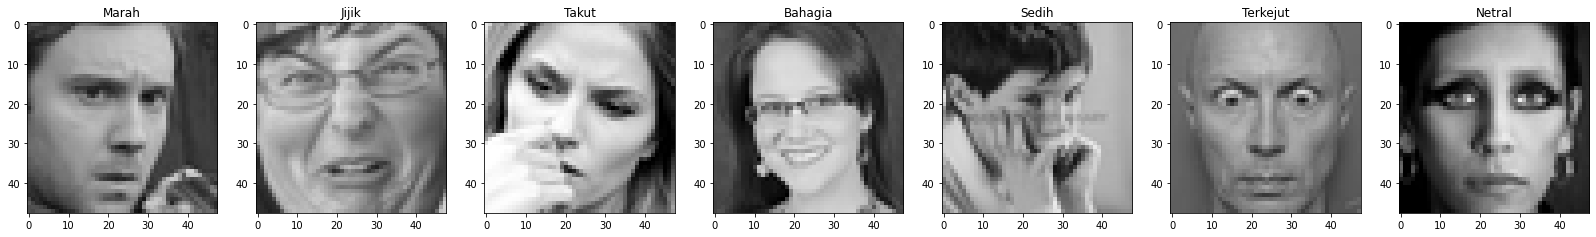

In [12]:
#Plot gambar RGB
fig,ax=plt.subplots(ncols=7,figsize=(28,4))
for i in range(7):
    ax[i].imshow(X_rgb[np.where(data['label'].values==i)][0])
    ax[i].set_title(emotions[i])

In [13]:
#Scaling gambar dengan membagi pixel value dengan 255
X_scaled=X_rgb/255


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Melakukan augmentasi gambar, dirotasi, zoom, shear, flip, dan digeser
dataAugmentaion = ImageDataGenerator(rotation_range = 30, zoom_range = 0.20, 
fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
width_shift_range = 0.1, height_shift_range = 0.1)

In [15]:
#Melakukan one hot encoding terhadap label target, dimana masing-masing label dijadikan kolom dan masing-masing kolom
#nilainya 1 atau 0
y=pd.get_dummies(data['label'])

In [16]:
#Memisahkan dataset menjadi data training dan testing
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,stratify=y,test_size=0.3,random_state=50)

In [17]:
print(X_train.shape) #Ukuran training feature
print(X_test.shape) #Ukuran test feature
print(y_train.shape) #Ukuran training label
print(y_test.shape) #Ukuran test label

(25120, 48, 48, 3)
(10767, 48, 48, 3)
(25120, 7)
(10767, 7)


In [18]:
#Definisikan model ResNet50 dengan input shape 48x48x3, include_top=False diset supaya baris pertama disertakan dalam training, weight diset imagenet
#karena model pre-trained ResNet50 ditrain dengan data dari imagenet
base_model=tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights='imagenet')

model=tf.keras.Sequential() #Set model deep learning sequential
model.add(base_model) #Menambahkan model ResNet50 ke arsitektur model
model.add(layers.Flatten()) #Menambahkan layer flatten untuk mengubah ukuran gambar menjadi flat/2D array
model.add(layers.Dense(2048,activation='relu')) #Menambahkan layer Dense dengan input shape 2048 dan activation relu
model.add(layers.Dense(1024,activation='relu')) #Menambahkan layer Dense dengan input shape 1024 dan activation relu
model.add(layers.Dense(512,activation='relu')) #Menambahkan layer Dense dengan input shape 512 dan activation relu
model.add(layers.Dense(256,activation='relu')) #Menambahkan layer Dense dengan input shape 256 dan activation relu
model.add(layers.Dense(128,activation='relu')) #Menambahkan layer Dense dengan input shape 128 dan activation relu
model.add(layers.Dense(64,activation='relu')) #Menambahkan layer Dense dengan input shape 64 dan activation relu
model.add(layers.Dense(7,activation='softmax')) #Menambahkan output layer Dense dengan input shape 7 dan activation softmax

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              16779264  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

#Callback checkpoint untuk save model setiap menemukan metrik yang terbaik, disini diset validation loss
checkpoint = ModelCheckpoint('EmotionDetectionModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

#Callback untuk menghentikan training jika val_lossnya paling rendah dengan menunggu 3 epoch selanjutnya baru berhenti jika tidak ada improvisasi
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

#Mengurangi nilai learning rate ketika model tidak mengalami improvisasi selama 3 epoch berturut-turut
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

#Mengkompail arsitektur model, loss function, optimizer, dan metrik untuk selanjutnya ditraining
model.compile(loss='binary_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

#fitting model dengan data training yang dilakukan augmentasi dan disertakan juga data validasi, step per epoch diset
#sejumlah banyaknya data training/batch size, epoch diset maksimal 50 epoch dan disertakan juga callbacks yang sudah diset di atas
hist=model.fit_generator(dataAugmentaion.flow(X_train, y_train, batch_size = 32),
 validation_data = (X_test, y_test), steps_per_epoch = len(X_train) // 32,
 epochs = 50, callbacks=[checkpoint,earlystop,reduce_lr])

/Users/fahmimn21/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-09-22 20:37:14.188532: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-22 20:37:14.190776: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2021-09-22 20:37:16.058148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


785/785 [==============================] - ETA: 0s - loss: 0.3420 - accuracy: 0.3989

2021-09-22 20:39:49.710110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


785/785 [==============================] - 173s 212ms/step - loss: 0.3420 - accuracy: 0.3989 - val_loss: 0.3537 - val_accuracy: 0.3894

Epoch 00001: val_loss improved from inf to 0.35367, saving model to EmotionDetectionModel.h5


/Users/fahmimn21/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
785/785 [==============================] - 162s 206ms/step - loss: 0.2976 - accuracy: 0.4997 - val_loss: 0.2748 - val_accuracy: 0.5443

Epoch 00002: val_loss improved from 0.35367 to 0.27484, saving model to EmotionDetectionModel.h5
Epoch 3/50
785/785 [==============================] - 166s 211ms/step - loss: 0.2816 - accuracy: 0.5305 - val_loss: 0.2658 - val_accuracy: 0.5635

Epoch 00003: val_loss improved from 0.27484 to 0.26579, saving model to EmotionDetectionModel.h5
Epoch 4/50
785/785 [==============================] - 170s 217ms/step - loss: 0.2691 - accuracy: 0.5599 - val_loss: 0.2623 - val_accuracy: 0.5733

Epoch 00004: val_loss improved from 0.26579 to 0.26232, saving model to EmotionDetectionModel.h5
Epoch 5/50
785/785 [==============================] - 170s 216ms/step - loss: 0.2618 - accuracy: 0.5703 - val_loss: 0.2519 - val_accuracy: 0.5959

Epoch 00005: val_loss improved from 0.26232 to 0.25195, saving model to EmotionDetectionModel.h5
Epoch 6/50
785/785 [====

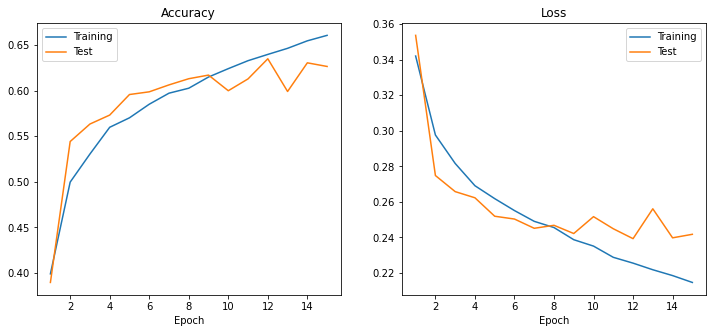

In [26]:
fig,ax=plt.subplots(ncols=2,figsize=(12,5))
epochs=len(hist.history['accuracy'])
ax[0].plot(range(1,epochs+1),hist.history['accuracy'],label='Training')
ax[0].plot(range(1,epochs+1),hist.history['val_accuracy'],label='Test')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

ax[1].plot(range(1,epochs+1),hist.history['loss'],label='Training')
ax[1].plot(range(1,epochs+1),hist.history['val_loss'],label='Test')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

In [25]:
from sklearn.metrics import classification_report

y_pred=np.round(model.predict(X_scaled))

print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.55      0.60      4953
           1       0.88      0.37      0.52       547
           2       0.65      0.37      0.47      5121
           3       0.85      0.88      0.87      8989
           4       0.68      0.42      0.52      6077
           5       0.77      0.77      0.77      4002
           6       0.64      0.65      0.64      6198

   micro avg       0.73      0.62      0.67     35887
   macro avg       0.73      0.57      0.63     35887
weighted avg       0.72      0.62      0.66     35887
 samples avg       0.62      0.62      0.62     35887



/Users/fahmimn21/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
